In this work we look at Spotify's Weekly Top 200 Music Streaming Data between 2021/02/04 ~ 2022/07/14 and see what knowledge we can draw from that.
Source: https://www.kaggle.com/datasets/yelexa/spotify200

<span style="font-size: 1.5em; font-weight: bold;">Import Data</span>

In [2]:
import pandas as pd
data = pd.read_csv('./Kaggle/spotify_data.csv')

/var/folders/l6/tjlgykc15tlfqn5g61st3ks00000gn/T/ipykernel_84671/701093725.py:2: DtypeWarning: Columns (2,4,9,12,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./Kaggle/spotify_data.csv')


In [3]:
# set data type for columns from DtypeWarning
float_set = [2,4,9,12,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,35]
# 'release_date' and 'week'
date_set = [11, 19]

# data from 'Global' and 'Weekly Top Songs' charts for each country charts from the week of 2016/12/29 ~ 2022/07/14
data.iloc[:, float_set] = data.iloc[:, float_set].apply(pd.to_numeric, errors='coerce').astype(float)
data['week'] = pd.to_datetime(data['week'], format='%Y-%m-%d', errors='coerce')
data['release_date'] = pd.to_datetime(data['release_date'], format='%Y-%m-%d', errors='coerce')

# data only from 'Weekly' charts from 2021/02/04 ~ 2022/07/14
data_global = data[data['week'] < '2021-02-04']
data = data.loc[data['week'] >= '2021-02-04']

# print data
total_rows = data.shape[0]
print('Total rows:', total_rows)
data.head()

Total rows: 1715436


,Unnamed: 0,uri,rank,artist_names,artists_num,artist_individual,artist_id,artist_genre,artist_img,collab,...,acousticness,instrumentalness,liveness,valence,tempo,duration,country,region,language,pivot
0,0,spotify:track:2gpQi3hbcUAcEG8m2dlgfB,1.0,Paulo Londra,1.0,Paulo Londra,spotify:artist:3vQ0GE3mI0dAaxIMYe5g7z,argentine hip hop,https://i.scdn.co/image/ab6761610000e5ebf796a9...,0.0,...,0.0495,0.000000,0.0658,0.557,173.935,178203.0,Argentina,South America,Spanish,0.0
1,1,spotify:track:2x8oBuYaObjqHqgGuIUZ0b,2.0,WOS,1.0,WOS,spotify:artist:5YCc6xS5Gpj3EkaYGdjyNK,argentine indie,https://i.scdn.co/image/ab6761610000e5eb75e151...,0.0,...,0.7240,0.000000,0.1340,0.262,81.956,183547.0,Argentina,South America,Spanish,0.0
2,2,spotify:track:2SJZdZ5DLtlRosJ2xHJJJa,3.0,Paulo Londra,1.0,Paulo Londra,spotify:artist:3vQ0GE3mI0dAaxIMYe5g7z,argentine hip hop,https://i.scdn.co/image/ab6761610000e5ebf796a9...,0.0,...,0.2410,0.000000,0.0929,0.216,137.915,204003.0,Argentina,South America,Spanish,0.0
3,3,spotify:track:1O2pcBJGej0pmH2Y9XZMs6,5.0,Cris Mj,1.0,Cris Mj,spotify:artist:1Yj5Xey7kTwvZla8sqdsdE,urbano chileno,https://i.scdn.co/image/ab6761610000e5eb8f4ebc...,0.0,...,0.0924,0.000046,0.0534,0.832,96.018,153750.0,Argentina,South America,Spanish,0.0
4,4,spotify:track:1TpZKxGnHp37ohJRszTSiq,6.0,Emilia,1.0,Emilia,spotify:artist:0AqlFI0tz2DsEoJlKSIiT9,pop argentino,https://i.scdn.co/image/ab6761610000e5ebaf96d1...,0.0,...,0.0811,0.000063,0.1010,0.501,95.066,133895.0,Argentina,South America,Spanish,0.0


We now llo at the share of data per region in percent:

In [4]:
regions = ['Europe', 'Africa', 'Asia', 'South America', 'North America', 'Oceania', 'Central America', 'Caribbean', 'Middle East', 'Global']
print('The share of data per region in %:')
for region in regions:
    print(region + ': %.1f %%' %((100/total_rows) * data[data['region'] == region].shape[0]))

The share of data per region in %:
Europe: 41.0 %
Africa: 3.5 %
Asia: 13.5 %
South America: 15.9 %
North America: 4.1 %
Oceania: 2.5 %
Central America: 10.1 %
Caribbean: 1.8 %
Middle East: 6.1 %
Global: 1.4 %


<span style="font-size: 1.5em; font-weight: bold;">A look at listening behavior in different regions of the world</span>

We now look at all musical features from the original dataset such as 'danceability', 'energy', 'loudness',etc. to visualise for any given feature how much it contributes to song popularity in any given region, i.e. the corralation between a feature and streaming behavior in any given region. We accomplish this by cumputing the pearson correlation coefficient which is a measure of the linear correlation between two variables. It ranges from -1 to 1, where -1 indicates a strong negative correlation, 0 indicates no correlation, and 1 indicates a strong positive correlation. The Pearson correlation coefficient is sensitive to the shape of the relationship between the two variables.

We now compute the correlation coefficient for every feature in every region.

In [6]:
from scipy.stats import pearsonr
corr_data = []
all_features = ['danceability', 'energy', 'key', 'mode', 'loudness',
                'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo', 'duration']

for feature in all_features:
    corr_data_f = []
    for region in regions:
        # get data for respective region
        data_regional = data.loc[data['region'] == region]

        # drop all rows with NaN values
        data_regional.dropna(inplace=True)

        # get relevant data
        f = data_regional[feature]
        s = data_regional['streams']

        # calculate the Pearson correlation coefficient and p-value
        corr, p_val = pearsonr(f, s)
        if p_val < 0.05: # correlation may exist
            corr_data_f.append(corr) # is it okay to just forget about the p_value, and to only plot the correlation coeff later?
        else : # correlation doesnt exist
            corr_data_f.append(0)
    corr_data.append(corr_data_f)

/var/folders/l6/tjlgykc15tlfqn5g61st3ks00000gn/T/ipykernel_84671/2385526247.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regional.dropna(inplace=True)


We now use a radar chart to visualise the differences in importance of each feature to song popularity for each region separately. The further away the dot for the respective region from the red circle the higher is the correlation.

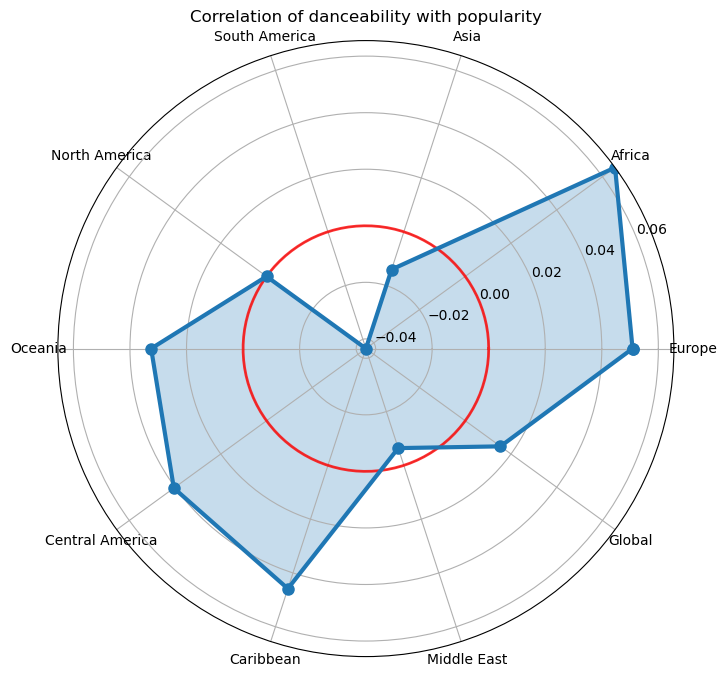

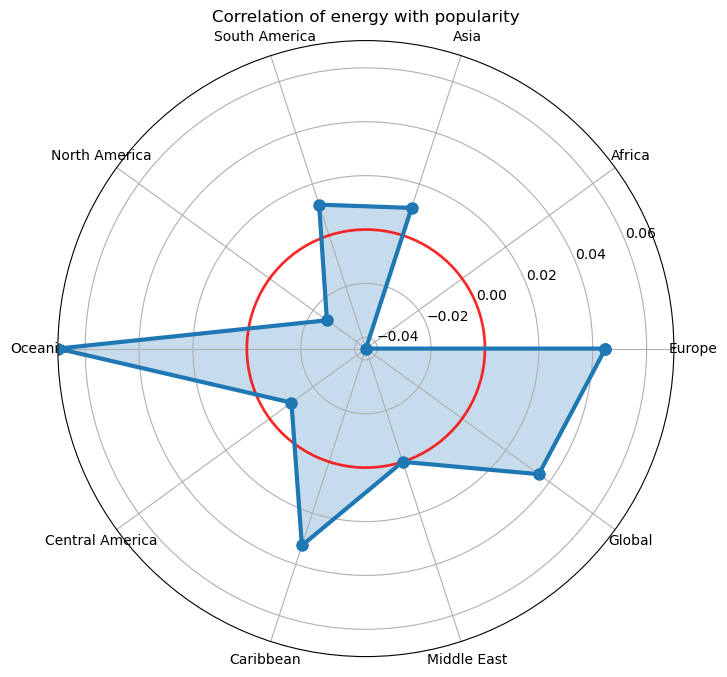

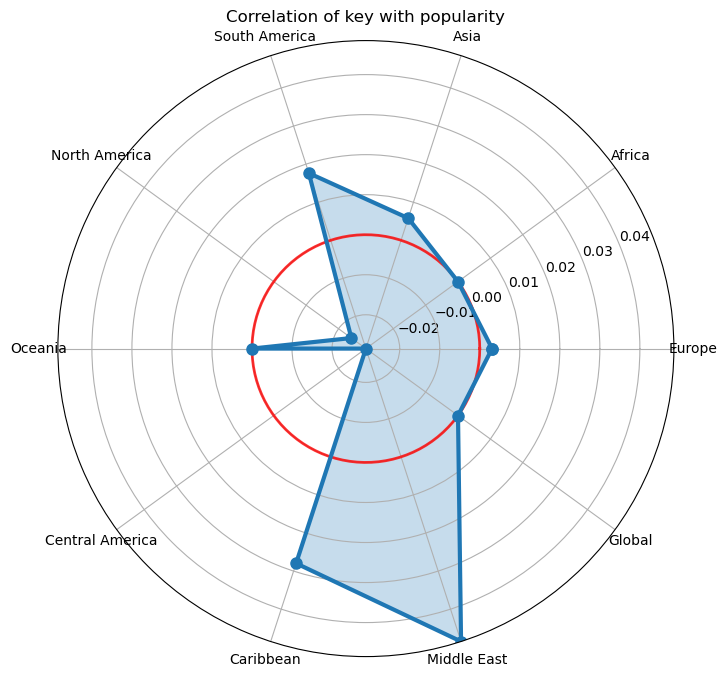

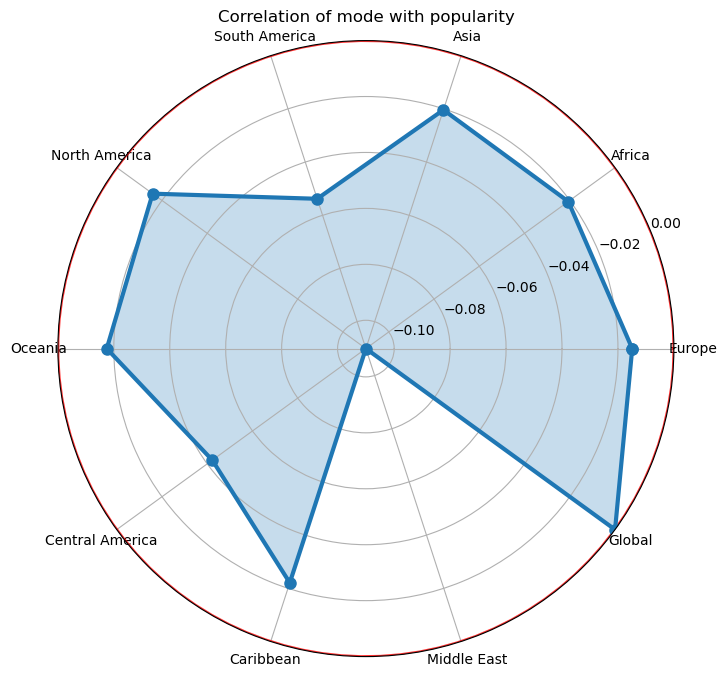

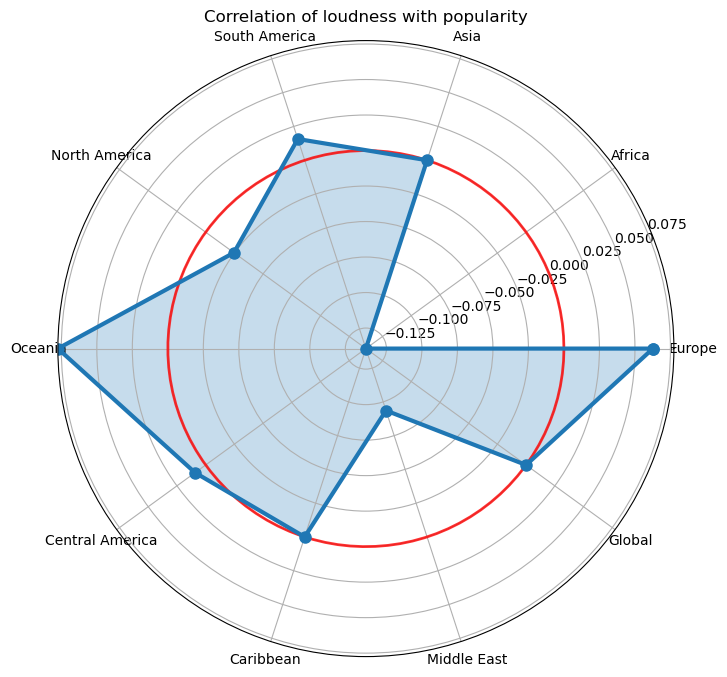

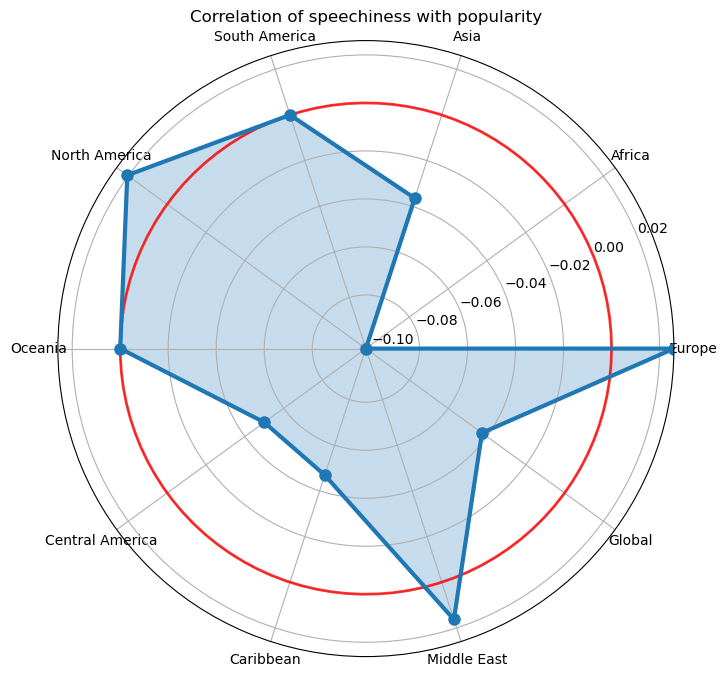

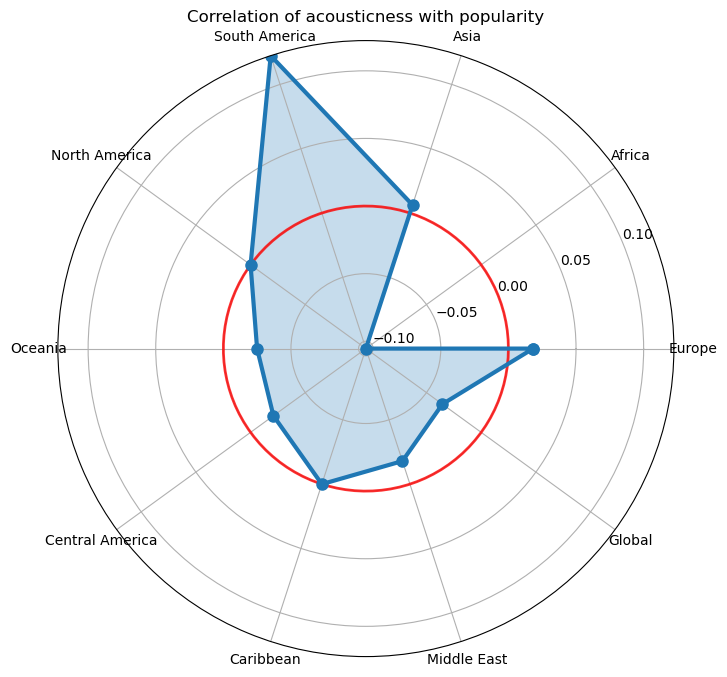

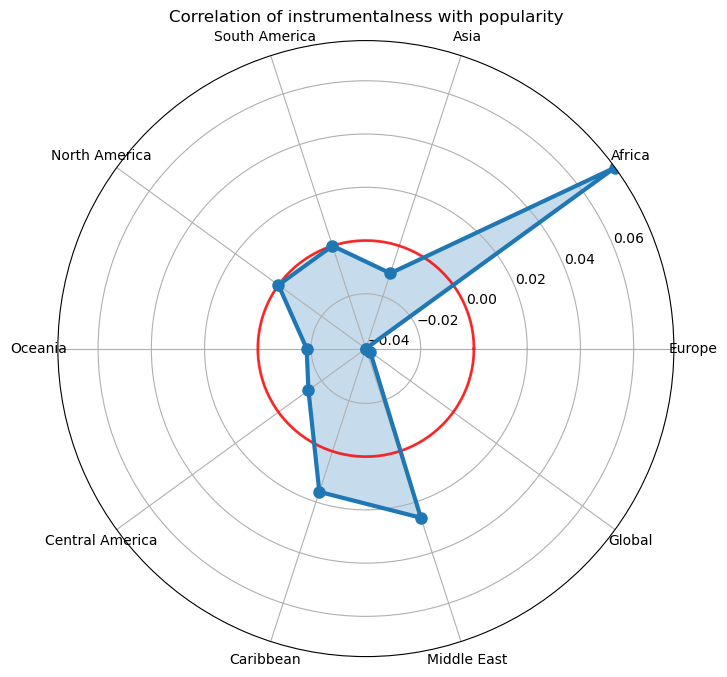

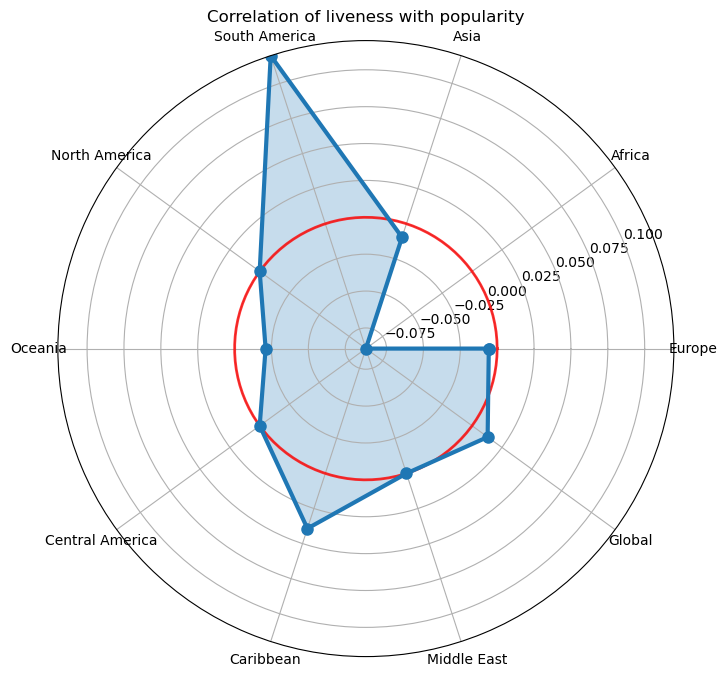

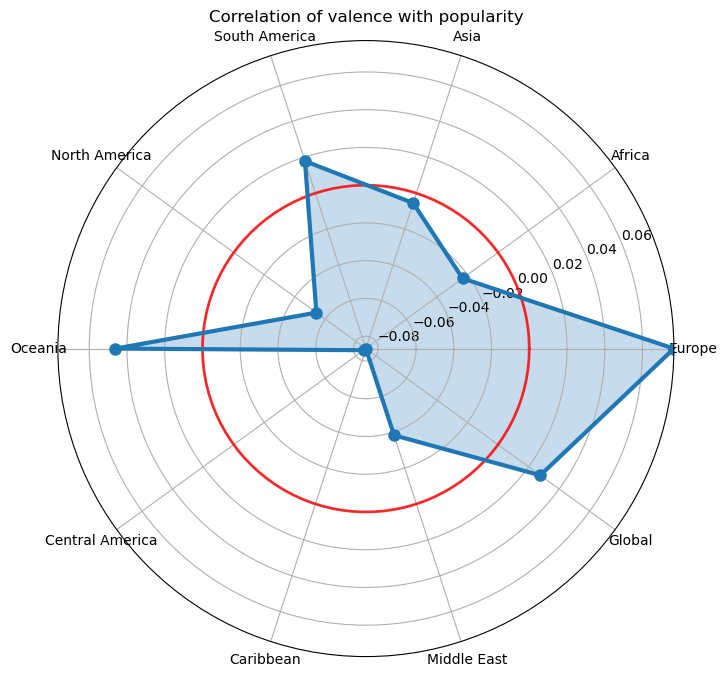

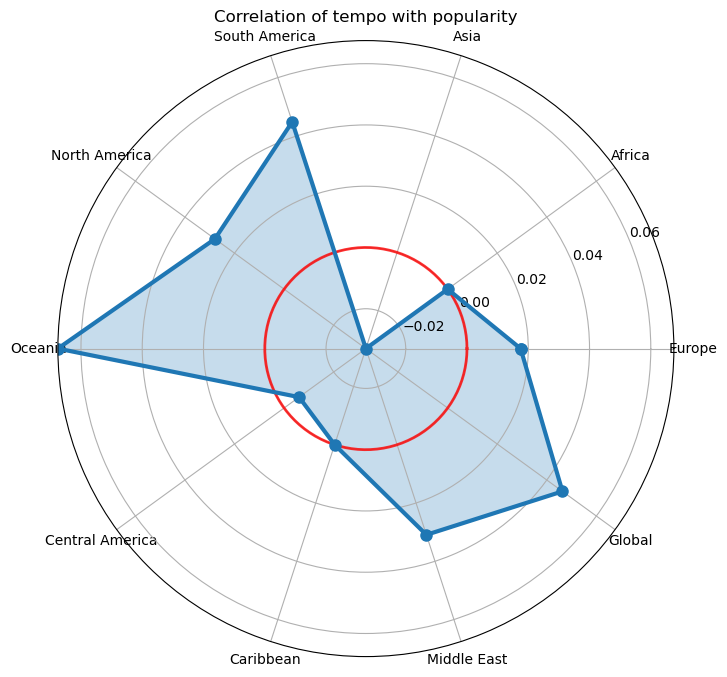

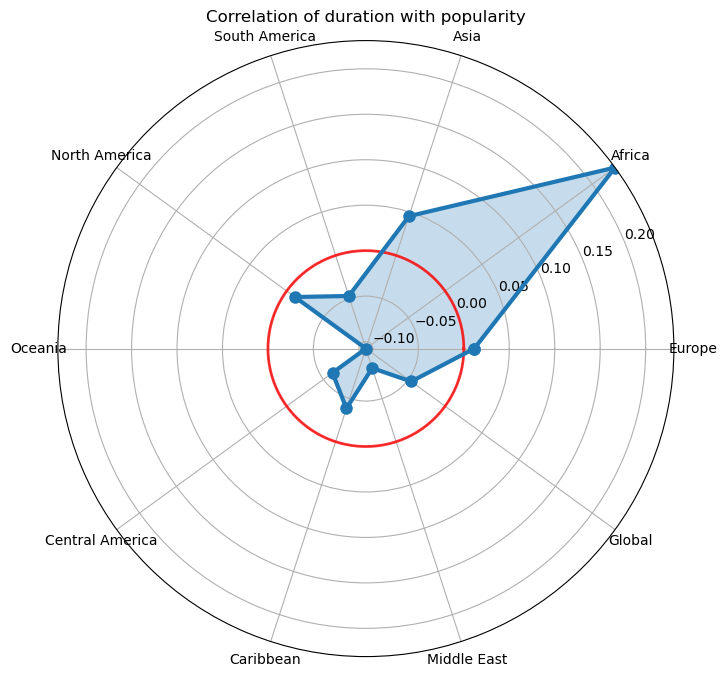

In [7]:
import matplotlib.pyplot as plt
import numpy as np

for coeffs, feature in zip(corr_data, all_features):
    # Set up the radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Calculate the angles for each data point
    n = len(coeffs)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    coeffs = np.concatenate((coeffs, [coeffs[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    # Plot a circle at value 0 in red which indicates the level of no correlation exists (p-value was 0)
    zero_angle = np.linspace(0, 2*np.pi, 100)
    zero_value = np.zeros_like(zero_angle)
    ax.plot(zero_angle, zero_value, color='red', linewidth=2, alpha=0.8)
    ax.plot(angles, coeffs, 'o-', linewidth=3, markersize=8)

    # Plot the data as a filled polygon
    ax.fill(angles, coeffs, alpha=0.25)
    ax.set_ylim(min(coeffs), max(coeffs))
    ax.set_thetagrids(angles[:-1] * 180/np.pi, regions)
    ax.set_title('Correlation of {} with popularity'.format(feature))
    ax.grid(True)
    plt.show()

Now that we looked at the isolated relationship of a feature and it's effects on the popularity of a song, we now try to find popular song tones, i.e. a combination of n featurues that sound appealing to a listener in a certain region and ultimatley drive popularity.

<span style="font-size: 1.5em; font-weight: bold;">Which song tones drive the popularity of songs in different regions</span>

Figuring out what musical features drive success of a song is everything but trivial. Different people have different musical taste, thus there could be a Rap song ranking at Nr.1 in the charts and a Techno song at Nr.2. There could even be two very different rap songs ranking at 1 and 2. Evidently there is no one rule which gives us the perfect balance between musical features ('danceability', 'energy', 'valence', etc.)  which guarantee a successfull song. We therefore perform a clustering analysis to group songs based on musical features alone. Then we look at the streaming performance and chart performance for each group, to then gain some insights into the types of songs that tend to perform well on the charts which tells us which musical features are associated with success. This information can be valuable for music producers and artists who are looking to create new music that is likely to perform well on the charts. Note: important to note that success is also influenced by timing, marketing and cultural circumstances such as language and location (maybe it would make sense to repeat this analysis for each region).

We also have to analyse music streaming behavior separately for each region since musical preference strongly varies between continents e.g. Europe and Africa.

To summarize, the goal here is not to find answer to the question of how to make a popular song, but rather to identify the small adjustments that can be made during production to enhance a song's overall appeal and, consequently, increase its popularity.

k-means clustering for each region:

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'tempo']
data_clustering_labels = []

n_clusters = 8

for region in regions:
    # get data for respective region
    data_regional = data.loc[data['region'] == region]
    # get data for relevant features, relevant features are those that a music producer can realistically control through things like recording techniques, instrumentation, and production choices.
    data_char = data_regional[features]
    # fill rows with nan with mean
    data_char.loc[:, :] = data_char.fillna(data_char.mean())

    # normalize the data
    scaler = StandardScaler()
    data_norm = scaler.fit_transform(data_char)

    # number of clusters
    k = n_clusters  # chosen with Elbow Method
    # Create the k-means object
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    # Fit the data to the k-means model
    kmeans.fit(data_norm)
    # Get the cluster labels
    labels = kmeans.predict(data_norm)

    # Add the cluster labels to the original dataset
    data_regional.loc[:, 'cluster'] = labels
    data_clustering_labels.append(data_regional)

/var/folders/l6/tjlgykc15tlfqn5g61st3ks00000gn/T/ipykernel_84671/1589402514.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_char.loc[:, :] = data_char.fillna(data_char.mean())
/var/folders/l6/tjlgykc15tlfqn5g61st3ks00000gn/T/ipykernel_84671/1589402514.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regional.loc[:, 'cluster'] = labels
/var/folders/l6/tjlgykc15tlfqn5g61st3ks00000gn/T/ipykernel_84671/1589402514.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

Finding out whether the data is normally distributed:

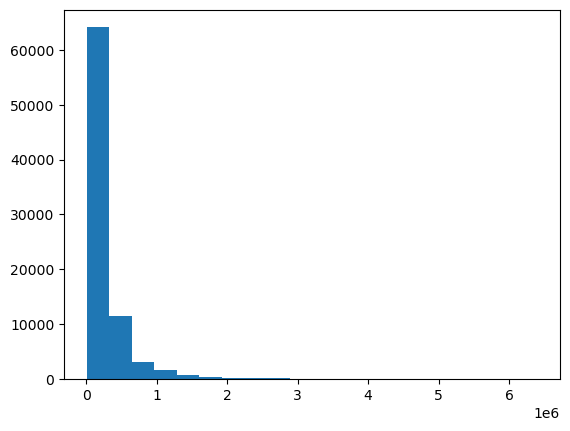

Test statistics: 0.5830294489860535
P-value: 0.0
The data is not normally distributed


/Users/joy.lucas/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
from scipy.stats import shapiro

data_cluster = data_clustering_labels[0]
data_cluster = data_cluster.loc[data_cluster['cluster'] == 6]['streams'] # this was tasted with a number of different clusters (all showed a similar distribution pattern)

plt.hist(data_cluster, bins=20)
plt.show()

# assuming your data is stored in a numpy array or a list named 'data'
stat, p_value = shapiro(data_cluster)

# print the test statistics and p-value
print("Test statistics:", stat)
print("P-value:", p_value)

# interpret the results
alpha = 0.05
if p_value > alpha:
    print("The data is normally distributed")
else:
    print("The data is not normally distributed")

Data distribution for each cluster of each region:

We are now looking for the statistics (avg, median, etc.) for each cluster of each region knowing that the data within a cluster is not normally distributed.

Our next task is to determine which clusters show good streaming performance using box plots:

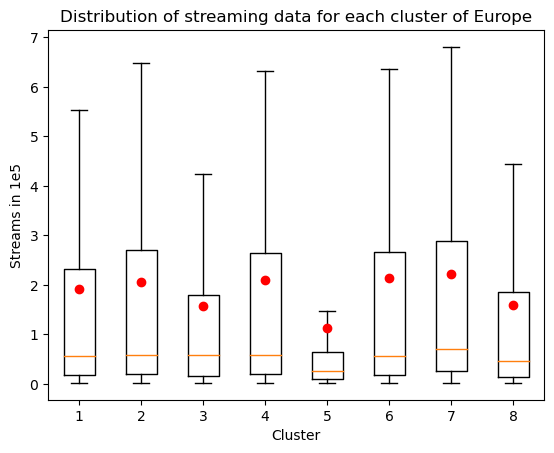

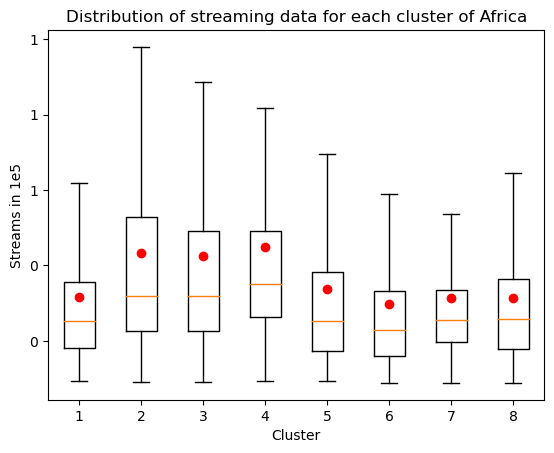

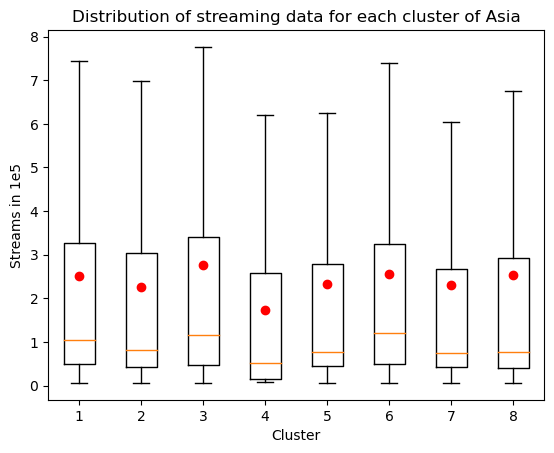

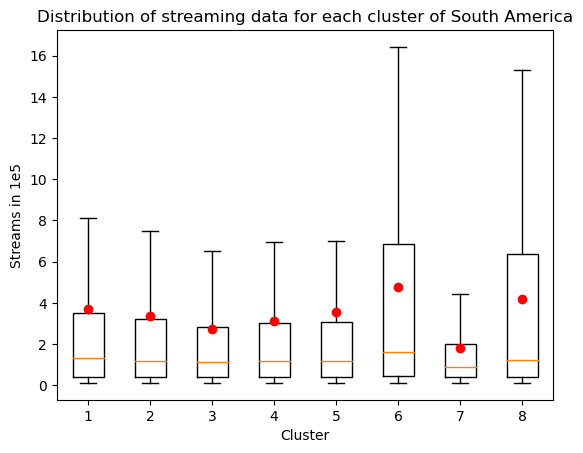

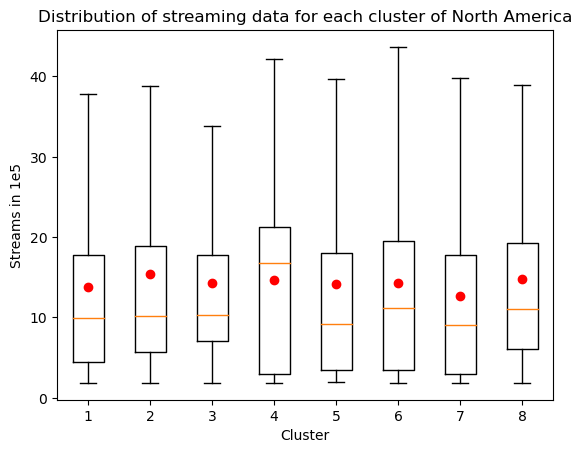

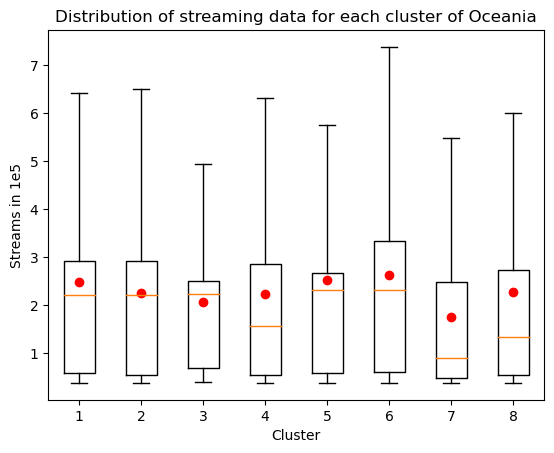

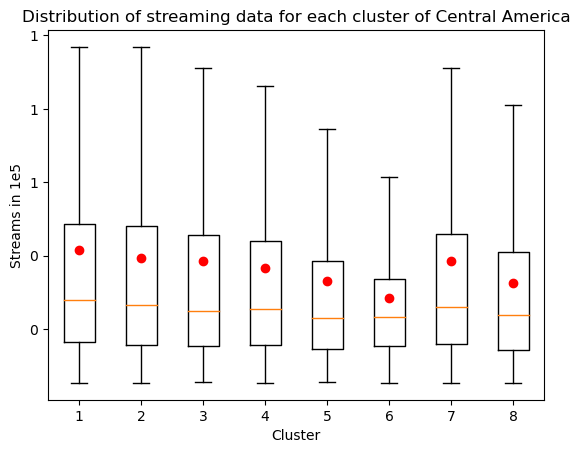

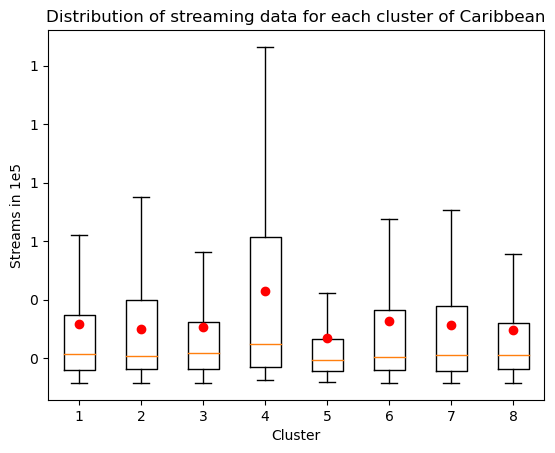

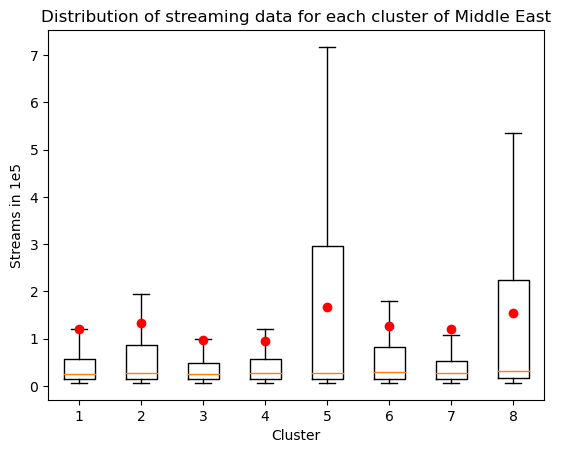

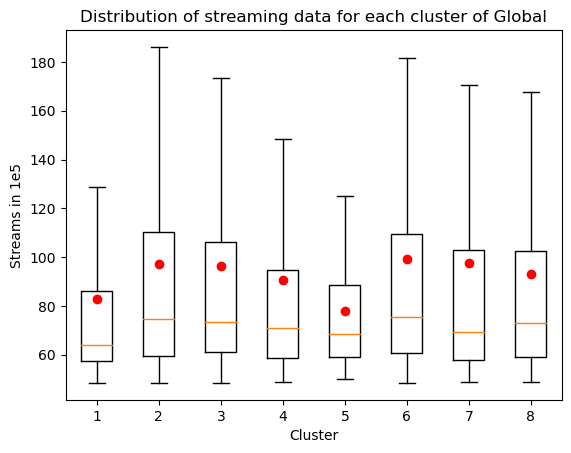

In [10]:
import matplotlib.ticker as ticker

for region, data_regional in zip(regions, data_clustering_labels):
    # Group the data by cluster and extract the streams column for each group
    grouped_data = [group['streams'] for name, group in data_regional.groupby('cluster')]

    # Create a box plot that shows the data for each cluster
    plt.boxplot(grouped_data, meanline=True, showfliers=False)

    means = [np.mean(x) for x in grouped_data]
    plt.plot(range(1, 9), means, 'ro')

    # Set the tick labels to show the full values
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1e5))) # '{:.0f}'.format)

    plt.title('Distribution of streaming data for each cluster of '+ region)
    plt.xlabel('Cluster')
    plt.ylabel('Streams in 1e5')
    plt.show()

Firstly we prioritize clusters with high median because the median is a good measure of central tendency of the streaming data since our has most likely outliers which excludes using the mean value. The IQR is the range between the 25th percentile (Q1) and the 75th percentile (Q3) of the data, it will be the second characteristic we look at because it is a useful measure of variability because it gives an idea of how spread out the middle 50% of the data is. A large IQR suggests that there is a lot of variability in the data, while a small IQR suggests that the data is more tightly clustered around the median.

In [11]:
def totalRange(q1, q3, iqr, data_c):
    """ Find the maximum value within the upper and lower fence """
    # Calculate the upper and lower fence as can be seen in the box plot
    upper_fence = q3 + 1.5 * iqr
    lower_fence = q1 - 1.5 * iqr

    top_whisker = np.max(data_c.loc[data_c['streams'] <= upper_fence, 'streams'])
    bottom_whisker = np.min(data_c.loc[data_c['streams'] >= lower_fence, 'streams'])
    return top_whisker - bottom_whisker

In [12]:
def evaluate(median, iqr, range_data, eps=1e4):
    """ Evaluates the median of a cluster given a certain iqr score """
    confidence = (100/range_data)*iqr # probability that 50% of data lies close to the median
    return median * ((confidence - 1) / 99) # reduce the median value given the confidence

In [13]:
# high performing clusters for each region
clusters_list = []
top_k_cluster = 2

for region, data_regional in zip(regions, data_clustering_labels):
    # compute the median and the IQR score for every cluster
    value_c = np.zeros(8)
    for i in range(n_clusters):
        median_c = data_regional.loc[data_regional['cluster'] == i, 'streams'].median()
        max_c = data_regional.loc[data_regional['cluster'] == i, 'streams'].max()
        min_c = data_regional.loc[data_regional['cluster'] == i, 'streams'].min()
        q1 = data_regional.loc[data_regional['cluster'] == i, 'streams'].quantile(0.25)
        q3 = data_regional.loc[data_regional['cluster'] == i, 'streams'].quantile(0.75)
        iqr = q3 - q1
        value_c[i] = evaluate(median_c, iqr, totalRange(q1, q3, iqr, data_regional[data_regional['cluster'] == i]))

    # select the n clusters with highest value
    k = top_k_cluster  # find the indices of the top 2 largest elements

    top_k_clusters = list(np.argpartition(value_c, -k)[-k:])
    clusters_list.append(top_k_clusters)

print('Top {} clusters for every region:\n {}' .format(top_k_cluster, clusters_list))

Top 2 clusters for every region:
 [[1, 6], [1, 3], [2, 5], [0, 5], [5, 3], [5, 2], [1, 0], [0, 3], [5, 7], [1, 5]]


We compute the range between 1st and 3rd quantile for every feature value of every cluster to only look at the range of values where 50% of all values are concentrated around the median. The combination of ranges (for each feature) for any given cluster than suggests a song tone that generally performs well streaming wise (using high performing clusters from above). We then plot a table which shows the ideal ranges for every cluster.

In [14]:
# get list of means of feature values for each cluster
values_list = np.zeros((20, 6, 2))
i = 0
for region, clusters, data_regional in zip(regions, clusters_list, data_clustering_labels):
    for cluster in clusters:
        values = []
        for feature in features: # ['danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'tempo']
            # get data for current region of current cluster from current feature
            data_feature = data_regional.loc[data_regional['cluster'] == cluster,  [feature]]
            Q1 = data_feature[feature].quantile(0.25)
            Q3 = data_feature[feature].quantile(0.75)
            values.append([Q1, Q3])
        values_list[i] = values
        i += 1

We now visualize the features for each cluster clusters.

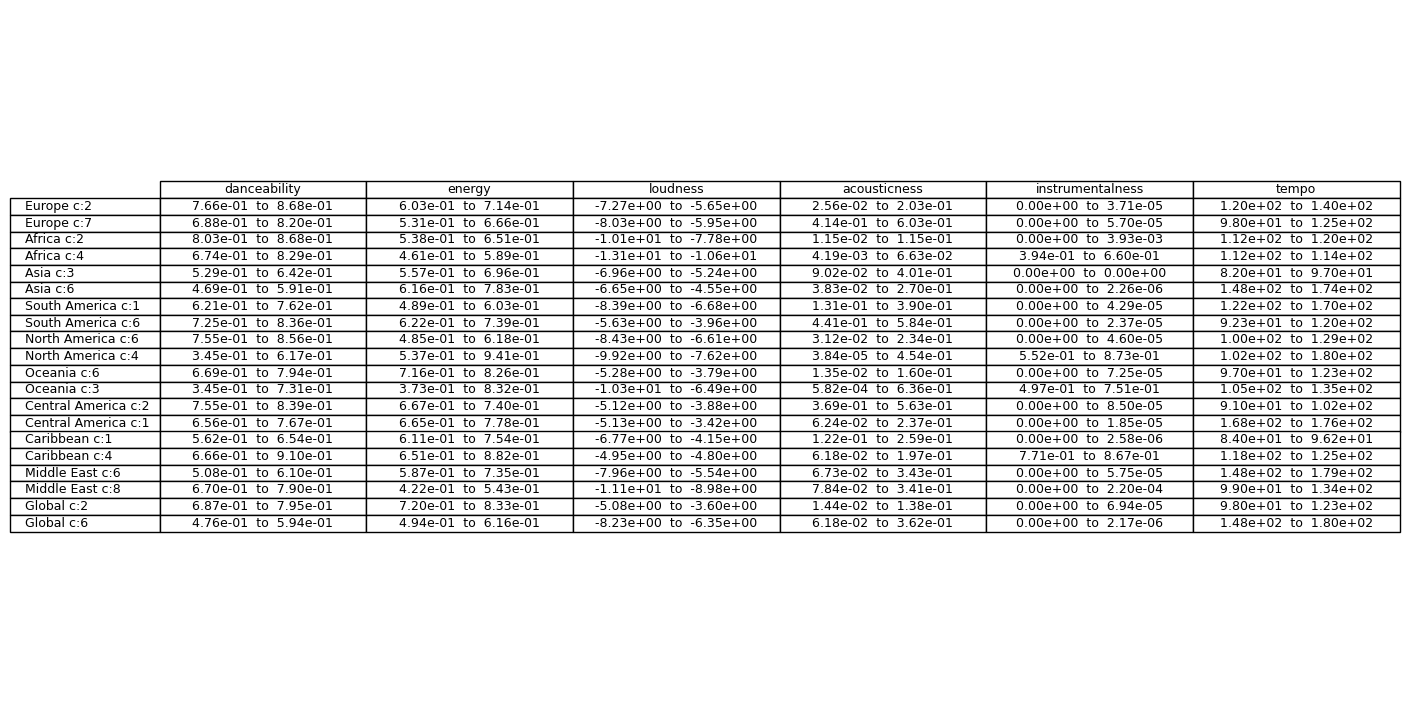

In [15]:
# set row description
data_t = []
row_labels = []
for region, clusters in zip(regions, clusters_list):
    for cluster in clusters:
        cell_text = f"{region} c:{cluster+1}"
        row_labels.append(cell_text)

# fill values
for i in range(values_list.shape[0]):
    row = []
    for j in range(values_list.shape[1]):
        if np.isnan(values_list[i,j,0]):
            cell_text = "nan (nan%)"
            row.append(cell_text)
        else:
            cell_text = f"{values_list[i,j,0]:.2e}  to  {values_list[i,j,1]:.2e}"
            row.append(cell_text)
    data_t.append(row)

# Plot the table
fig, ax = plt.subplots(figsize=(16, 9))
ax.table(cellText=data_t, loc='center', cellLoc='center', colLabels=features, rowLabels=row_labels)
ax.axis('off')
plt.show()

<span style="font-size: 1.5em; font-weight: bold;">Conclusion</span>

I can think of the following applications to the above results:

1) The results can be used to either create entirely new songs for any given region with the tone (combination of musical features) that can be derived from the table above.
2) By comparing the musical features of an already existing song and comparing them to any given cluster C from the table above, one can enhance the overall appeal of the song by adjusting the song at those features which dont lie in the relevant range of the feature in cluster C.
3) One can predict in which region of the world a given song performs best by comparing the musical features of that song every row essentially. Wherever the song fits best, is the region where we can likely expect the highest streaming numbers.


It must also be said that the region is a major factor in popularity. For instance, a Spanish song would generally be more popular than an english song in south america. The above work only tells us which features are most impactful for popularity globally and not for a specific region which we would have to analyse separately. Moreover, as we have shown at the beginning the data also doesn't really express global music streaming behavior since 41% of all the data is from europe, 13% Asia and 15% South America. Because of this unbalance we might have difficulties applying the knowledge gained from this analysis to regions like Africa and Asia. We therefore must definitely collect more data globally to gain more insight for global music streaming behavior.